# Sistema de Recomendação com Dot Product

Notebook 2 da série: demonstra, de forma didática e aplicada, como o produto escalar pode ranquear recomendações usando embeddings em cenários onde a intensidade da preferência importa.


## 1. Introdução
- **Produto escalar** mede quão alinhados dois vetores estão, levando em conta magnitude e direção.
- **Magnitudes importam**: vetores maiores significam preferências/intensidades altas; dot product preserva esse efeito.
- **Quando usar?** Recomendação com sinais fortes (ex.: notas explícitas, pesos de popularidade, propensão de compra).
- **Exemplo intuitivo:** pense em vetores 2D: `u = (2, 1)` (gosto moderado por cafés + doces) e `i = (3, 0.5)` (produto muito forte em cafés). Dot product grande sugere forte afinidade.


## 2. Mini teoria
- **Fórmula:** `u · v = Σ (u_i * v_i)`.
- **Interpretação geométrica:** `u · v = ||u|| * ||v|| * cos(θ)`; logo, quanto mais alinhados e “longos”, maior o valor.
- **Por que é ótimo para preferências?** Porque preserva tanto a direção (quais atributos importam) quanto a intensidade (quanto importam). Usuários muito engajados geram vetores maiores, dando mais peso ao ranking.


### Dependências utilizadas
Somente bibliotecas leves:


In [1]:
pip install --quiet numpy pandas matplotlib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\tbfel\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(21)
plt.style.use("seaborn-v0_8")


## 3. Demonstração intuitiva (2D)
Vamos visualizar um usuário e três itens em 2 dimensões (atributos: `cafés` e `doces`).


In [3]:
user_vec = np.array([2.0, 1.0])  # gosta mais de cafés do que doces
items = {
    "Expresso Intenso": np.array([3.5, 0.5]),
    "Latte Cremoso": np.array([2.2, 1.5]),
    "Bolo de Chocolate": np.array([0.5, 3.0]),
}


def dot(a, b):
    return float(np.dot(a, b))


scores = {name: dot(user_vec, vec) for name, vec in items.items()}
pd.DataFrame.from_dict(scores, orient="index", columns=["dot_product"]).sort_values(by="dot_product", ascending=False)


,dot_product
Expresso Intenso,7.5
Latte Cremoso,5.9
Bolo de Chocolate,4.0


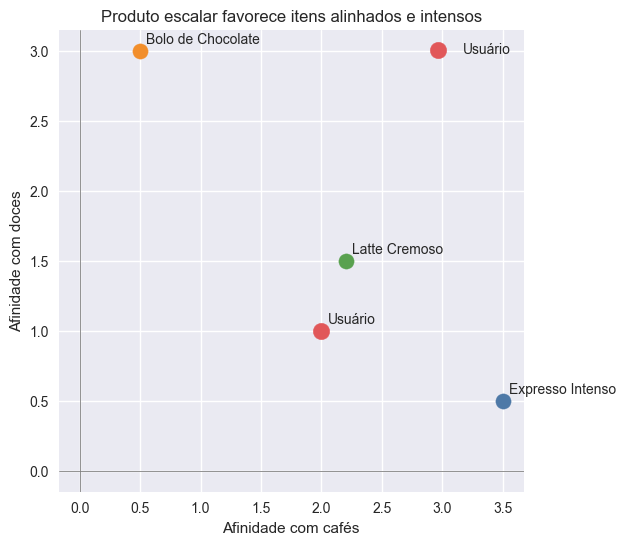

In [4]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(user_vec[0], user_vec[1], c="#E15759", s=140, label="Usuário")

colors = ["#4E79A7", "#59A14F", "#F28E2B"]
for (name, vec), color in zip(items.items(), colors):
    ax.scatter(vec[0], vec[1], c=color, s=120)
    ax.annotate(name, (vec[0] + 0.05, vec[1] + 0.05))

ax.annotate("Usuário", (user_vec[0] + 0.05, user_vec[1] + 0.05))
ax.set_xlabel("Afinidade com cafés")
ax.set_ylabel("Afinidade com doces")
ax.set_title("Produto escalar favorece itens alinhados e intensos")
ax.axhline(0, color="gray", linewidth=0.6)
ax.axvline(0, color="gray", linewidth=0.6)
ax.legend()
plt.show()


## 4. Implementação prática em Python
Vamos gerar embeddings sintéticos (dimensão 4) para usuários e empresas, calcular produtos escalares e montar rankings.


In [5]:
NUM_USERS = 4
NUM_ITEMS = 6
EMBED_DIM = 4

user_ids = [f"U{i+1}" for i in range(NUM_USERS)]
item_ids = [f"Empresa {chr(65+i)}" for i in range(NUM_ITEMS)]

# Usuários com intensidades diferentes (escala 0-3 + ruído)
user_embeddings = np.abs(np.random.randn(NUM_USERS, EMBED_DIM) * np.array([3, 2, 1.5, 2]))
item_embeddings = np.abs(np.random.randn(NUM_ITEMS, EMBED_DIM) * np.array([2.5, 2, 1.8, 1.2]))

users_df = pd.DataFrame(user_embeddings, columns=[f"dim_{i+1}" for i in range(EMBED_DIM)])
users_df.insert(0, "user_id", user_ids)
items_df = pd.DataFrame(item_embeddings, columns=[f"dim_{i+1}" for i in range(EMBED_DIM)])
items_df.insert(0, "item_id", item_ids)

users_df, items_df


(  user_id     dim_1     dim_2     dim_3     dim_4
 0      U1  0.155893  0.222392  1.562695  2.513479
 1      U2  2.236163  3.422108  0.308797  0.469143
 2      U3  3.384432  0.025252  0.919800  2.747377
 3      U4  4.832976  1.378457  1.037886  0.896231,
      item_id     dim_1     dim_2     dim_3     dim_4
 0  Empresa A  0.405856  0.514458  2.295821  0.076805
 1  Empresa B  2.654642  1.978737  0.823902  2.381018
 2  Empresa C  3.691105  0.463606  1.159487  1.022547
 3  Empresa D  1.160047  1.394353  2.822188  1.414267
 4  Empresa E  3.459892  3.494668  0.724903  1.493379
 5  Empresa F  0.059591  1.905135  0.440935  0.268917)

In [6]:
def recommend_dot_product(user_id: str, top_k: int = 3) -> pd.DataFrame:
    user_row = users_df.set_index("user_id").loc[user_id].values
    scores = item_embeddings @ user_row  # produto escalar via matriz
    ranking = (
        pd.DataFrame({"item_id": item_ids, "dot_product": scores})
        .sort_values(by="dot_product", ascending=False)
        .head(top_k)
        .reset_index(drop=True)
    )
    return ranking


rec_example = recommend_dot_product(user_ids[0], top_k=5)
rec_example


,item_id,dot_product
0,Empresa D,8.455886
1,Empresa B,8.126040
2,Empresa E,6.202938
3,Empresa C,5.060594
4,Empresa A,3.958398


> **Como ler o ranking?** Quanto maior o dot product, maior a afinidade entre o vetor de preferências do usuário e o vetor de atributos da empresa. Diferente do cosseno, aqui empresas com “força” alta em atributos desejados sobem na lista.


In [7]:
def recommend_all(top_k: int = 3) -> pd.DataFrame:
    frames = []
    for uid in user_ids:
        ranking = recommend_dot_product(uid, top_k)
        ranking.insert(0, "user_id", uid)
        frames.append(ranking)
    return pd.concat(frames, ignore_index=True)

recommend_all(top_k=3)


,user_id,item_id,dot_product
0,U1,Empresa D,8.455886
1,U1,Empresa B,8.126040
2,U1,Empresa E,6.202938
3,U2,Empresa E,20.620467
4,U2,Empresa B,14.079116
5,U2,Empresa C,10.678189
6,U3,Empresa E,16.567659
7,U3,Empresa C,16.379821
8,U3,Empresa B,16.333800
9,U4,Empresa E,23.629602


## 5. Integração com PostgreSQL + pgvector (conceitual)
A seguir um exemplo em SQL para armazenar embeddings e consultar recomendações usando o operador `<#>` (produto interno) com índice HNSW.


```sql
-- 1. Criar tabela com tipo vector
CREATE TABLE match_users (
    id SERIAL PRIMARY KEY,
    nome TEXT,
    embedding vector(4)
);

CREATE TABLE match_companies (
    id SERIAL PRIMARY KEY,
    nome TEXT,
    embedding vector(4)
);

-- 2. Inserir exemplos (representados aqui como arrays)
INSERT INTO match_users (nome, embedding)
VALUES
  ('Usuário 1', '[1.2, 0.8, 0.1, 0.4]'),
  ('Usuário 2', '[2.8, 1.1, 0.6, 1.5]');

INSERT INTO match_companies (nome, embedding)
VALUES
  ('Empresa A', '[1.5, 0.4, 0.3, 0.2]'),
  ('Empresa B', '[3.1, 1.3, 0.8, 1.1]'),
  ('Empresa C', '[0.4, 1.7, 2.2, 0.5]');

-- 3. Índice HNSW para produto interno (vector_ip_ops)
CREATE INDEX ON match_companies
USING hnsw (embedding vector_ip_ops);

-- 4. Query de recomendação (menor <#> == maior dot product)
WITH target AS (
  SELECT embedding FROM match_users WHERE nome = 'Usuário 2'
)
SELECT c.nome, c.embedding, c.embedding <#> target.embedding AS score
FROM match_companies c, target
ORDER BY score ASC
LIMIT 3;
```


## 6. Conclusão e próximos passos
- Dot product é ideal quando **intensidade importa** (likes, cliques, gasto, confiança do modelo).
- Cosine similarity serve quando queremos ignorar magnitude (textos com comprimentos distintos).
- Para escalar: combinar pgvector + índices ANN, pipelines de atualização de embeddings e filtros de negócio.
- Próximos notebooks cobrirão cosine similarity (busca semântica) e distância euclidiana (clustering/hard constraints).
